In [111]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from transformers import AutoModel, AutoTokenizer

from group_sae.utils import palette, cmap

## FLOPs

In [30]:
from torch.utils.flop_counter import FlopCounterMode

device = "cuda"

# Load GPT-2 model and tokenizer
model_name = "EleutherAI/pythia-1b-deduped"
model = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

model.to(device)
model.eval()
print("Model running on", device)

Model running on cuda


In [31]:
N_TOKENS = 1e9
ctx_len = 1024
d_model = 2048
n_layers = 16
n_batches = N_TOKENS // ctx_len

In [ ]:
# Prepare a sample input with 1024 tokens
input_text = "Sample input."
input_text += " null" * (ctx_len - len(tokenizer(input_text)["input_ids"]))
inputs = tokenizer(input_text, return_tensors="pt")["input_ids"]
print(f"Input shape: {inputs.shape}")

cache = {}


def forward_hook(module, input, output):
    cache["output"] = output[0].flatten(0, 1)


model.layers[0].register_forward_hook(forward_hook)

# Enable flop counting
with FlopCounterMode(model) as flop_counter:
    with torch.no_grad():
        outputs = model(inputs.to(device))

# Retrieve FLOPs count
flops = flop_counter.get_total_flops() * n_batches
print(f"PFLOPs required for caching 1B tokens: {flops / 1e15:.2f} PFLOPs")

Input shape: torch.Size([1, 1024])
Module                                                FLOP    % Total
-----------------------------------------------  ---------  ---------
GPTNeoXModel                                     1786.706B    100.00%
 - aten.bmm                                         0.000B      0.00%
 - aten.addmm                                    1649.267B     92.31%
 - aten._scaled_dot_product_efficient_attention   137.439B      7.69%
 GPTNeoXModel.rotary_emb                            0.000B      0.00%
  - aten.bmm                                        0.000B      0.00%
PFLOPs required for caching 1B tokens: 1744.83 PFLOPs


/tmp/ipykernel_4316/3655135618.py:14: UserWarning: mods argument is not needed anymore, you can stop passing it
  with FlopCounterMode(model) as flop_counter:


In [33]:
import torch.nn as nn


# We use a standard SAE as FLOP count doesn't change between architectures.
class SAE(nn.Module):
    def __init__(self, c, sparsity=1):
        super(SAE, self).__init__()
        self.sparsity = sparsity
        self.encoder = nn.Linear(d_model, d_model * c)
        self.decoder = nn.Linear(d_model * c, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        h = self.encoder(x)
        h = self.relu(h)
        return self.decoder(h), h

    def get_loss(self, x, y):
        x_hat, h = self(x)
        l2_loss = (x_hat - y).pow(2).sum()
        fvu = l2_loss / x.pow(2).sum()
        l1_loss = h.abs().sum(-1).mean()
        print(f"l2_loss: {l2_loss.item()}, l1_loss: {l1_loss.item()}")
        return fvu + l1_loss * self.sparsity

In [34]:
def training_step(sae, inputs, optimizer):
    optimizer.zero_grad()
    loss = sae.get_loss(inputs, inputs)
    loss.backward()
    optimizer.step()


c = 16

sae = SAE(c=c, sparsity=1)
sae.to(device)
optimizer = torch.optim.Adam(sae.parameters(), lr=1e-3)

In [35]:
# Enable flop counting
with FlopCounterMode(sae) as flop_counter:
    training_step(sae, cache["output"], optimizer)

# Retrieve FLOPs count
flops = flop_counter.get_total_flops() * n_batches  # * n_layers
print(f"PFLOPs for the forward pass: {flops / 1e15:.2f} PFLOPs")

l2_loss: 909004.0, l1_loss: 4792.55224609375
Module               FLOP    % Total
---------------  --------  ---------
Global           687.195B    100.00%
 - aten.addmm    274.878B     40.00%
 - aten.mm       412.317B     60.00%
 SAE             412.317B     60.00%
  - aten.addmm   274.878B     40.00%
  - aten.mm      137.439B     20.00%
  SAE.decoder    412.317B     60.00%
   - aten.addmm  137.439B     20.00%
   - aten.mm     274.878B     40.00%
  SAE.encoder    274.878B     40.00%
   - aten.addmm  137.439B     20.00%
   - aten.mm     137.439B     20.00%
PFLOPs for the forward pass: 671.09 PFLOPs


/tmp/ipykernel_4316/4198970078.py:2: UserWarning: mods argument is not needed anymore, you can stop passing it
  with FlopCounterMode(sae) as flop_counter:


| Model       |  L |    D |       A |      T |
|-------------|----|------|---------|--------|
| Pythia-160m | 12 |  768 |  207.62 |  94.37 |
| Pythia-410m | 24 | 1024 |  704.64 | 167.77 |
| Pythia-1b   | 16 | 2048 | 1744.83 | 671.09 |

All results are in PFLOPs (1e15)

## AMD

In [25]:
import numpy as np

from group_sae import MODEL_MAP
from group_sae.utils import load_amds, load_cluster_map

columns = ["ce_loss_score", "delta_ce", "explained_variance", "mse", "l2_ratio", "layer", "G"]

def delta_ce(df):
    return (df["ce_loss_with_sae"] - df["ce_loss_without_sae"]) / df["ce_loss_without_sae"] * 100

def load_cluster_eval(size, include_baseline=False):

    nl = MODEL_MAP[f"pythia-{size}"]["n_layers"]

    labels = []
    clusters = []
    for c in load_cluster_map(size).values():
        lab_ = list(dict.fromkeys(c))
        label_map = {v: i for i, v in enumerate(lab_)}
        clusters += [label_map[i] for i in c]
        labels += c
    labels += [f"layers.{i}" for i in range(nl-1)]
    clusters += list(range(nl-1))

    cluster_eval = pd.read_csv(f"../eval/pythia-{size}_cluster.csv", index_col=0)
    cluster_eval["delta_ce"] = delta_ce(cluster_eval)
    cluster_eval = cluster_eval[columns]
    cluster_eval["label"] = labels[: len(cluster_eval)]
    cluster_eval.drop(columns="G", inplace=True)

    base_eval = pd.read_csv(f"../eval/pythia-{size}_baseline.csv", index_col=0)
    base_eval["delta_ce"] = delta_ce(base_eval)
    base_eval = base_eval[columns]
    base_eval["label"] = base_eval["layer"].apply(lambda x: f"layers.{x}")
    base_eval.drop(columns="G", inplace=True)

    unique_eval = pd.concat([base_eval, cluster_eval]).drop_duplicates()

    empty_evals = pd.DataFrame(
        {"layer": list(range(nl-1)) * (nl-1), "cluster": clusters, "label": labels, "G": np.arange(1, nl).repeat(nl - 1)}
    )
    eval = pd.merge(empty_evals, unique_eval, how="left").drop(columns="label")
    eval = eval.groupby(["G", "cluster", "layer"]).mean().reset_index()

    # Fill AMDs
    amd = load_amds(size, include_baseline)

    return pd.merge(eval, amd, on="G")

In [122]:
p160 = load_cluster_eval("160m", include_baseline=True)
p410 = load_cluster_eval("410m", include_baseline=True)
p1 = load_cluster_eval("1b", include_baseline=True)

In [123]:
p160_plot = p160.groupby("G").mean()
p410_plot = p410.groupby("G").mean()
p1_plot = p1.groupby("G").mean()

In [124]:
base_160m = pd.read_csv("../eval/pythia-160m_baseline.csv", index_col=0)
base_160m["delta_ce"] = delta_ce(base_160m)
base_160m = base_160m[columns]

base_410m = pd.read_csv("../eval/pythia-410m_baseline.csv", index_col=0)
base_410m["delta_ce"] = delta_ce(base_410m)
base_410m = base_410m[columns]

base_1b = pd.read_csv("../eval/pythia-1b_baseline.csv", index_col=0)
base_1b["delta_ce"] = delta_ce(base_1b)
base_1b = base_1b[columns]

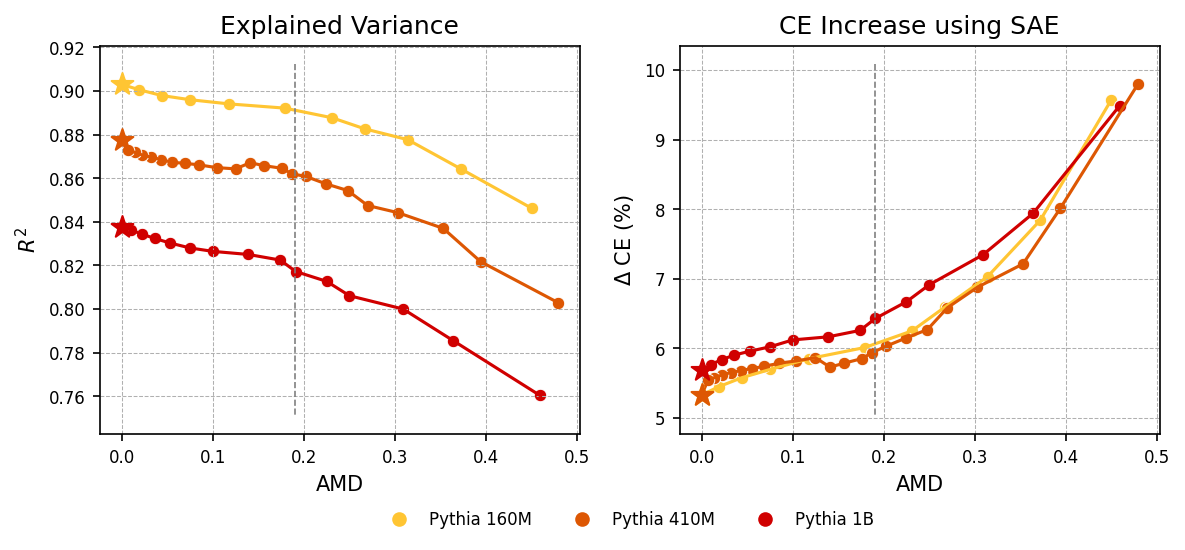

In [307]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(8, 3.5), dpi=150, layout="tight")

def plot_vs_amd(metric, ax):
    sns.lineplot(p160_plot, x="AMD", y=metric, color=palette[0], ax=ax)
    sns.scatterplot(p160_plot, x="AMD", y=metric, color=palette[0], ax=ax, legend=False)
    last_row = p160_plot.iloc[-1]
    ax.scatter(last_row["AMD"], last_row[metric], marker="*", s=120,
               color=palette[0], edgecolor=None, zorder=10)

    sns.lineplot(p410_plot, x="AMD", y=metric, color=palette[2], ax=ax)
    sns.scatterplot(p410_plot, x="AMD", y=metric, color=palette[2], ax=ax, legend=False)
    last_row = p410_plot.iloc[-1]
    ax.scatter(last_row["AMD"], last_row[metric], marker="*", s=120,
               color=palette[2], edgecolor=None, zorder=10)

    sns.lineplot(p1_plot, x="AMD", y=metric, color=palette[3], ax=ax)
    sns.scatterplot(p1_plot, x="AMD", y=metric, color=palette[3], ax=ax, legend=False)
    last_row = p1_plot.iloc[-1]
    ax.scatter(last_row["AMD"], last_row[metric], marker="*", s=120,
               color=palette[3], edgecolor=None, zorder=10)

    all_ = pd.concat([p160_plot, p410_plot, p1_plot])
    max_ = all_[metric].max()
    min_ = all_[metric].min()
    delta = (max_ - min_) / 15
    
    # Add vertical dashed line at x = 0.2
    ax.vlines(0.19, max_+delta, min_-delta, colors="grey", linestyles="--", linewidth=0.8)

    # Color the region between x = 0.18 and x = 0.22
    #ax.axvspan(0.18, 0.22, color="lightgray", alpha=0.2)  # Light gray with transparency

    ax.set_xlabel("AMD")
    ax.tick_params(labelsize=8)  # Reduce tick size

plot_vs_amd("explained_variance", ax[0])
ax[0].set_ylabel(r"$R^2$")
ax[0].set_title("Explained Variance")
ax[0].grid(linestyle="--", linewidth=0.5)

plot_vs_amd("delta_ce", ax[1])
ax[1].set_ylabel(r"$\Delta$ CE (%)")
ax[1].set_title("CE Increase using SAE")
ax[1].grid(linestyle="--", linewidth=0.5)

# Create a single unique legend without a frame
handles = [
    plt.Line2D([0], [0], marker='o', color=palette[0], linestyle='', label="Pythia 160M"),
    plt.Line2D([0], [0], marker='o', color=palette[2], linestyle='', label="Pythia 410M"),
    plt.Line2D([0], [0], marker='o', color=palette[3], linestyle='', label="Pythia 1B")
]
# bbox
fig.legend(handles=handles, loc="lower center", ncol=3, fontsize=8, frameon=False, bbox_to_anchor=(0.53, -0.05))
#fig.suptitle("AMD vs. Reconstruction metrics", fontsize=14)

plt.savefig("imgs/amd_vs_metrics.svg", bbox_inches="tight", dpi=300)
plt.show()

In [299]:
p160 = load_cluster_eval("160m", include_baseline=True)
p410 = load_cluster_eval("410m", include_baseline=True)
p1 = load_cluster_eval("1b", include_baseline=True)

In [286]:
p160_plot = p160.groupby("G").mean()
p410_plot = p410.groupby("G").mean()
p1_plot = p1.groupby("G").mean()

p160_plot["C_relative"] = p160_plot["C"] / p160_plot["C"].max()
p410_plot["C_relative"] = p410_plot["C"] / p410_plot["C"].max()
p1_plot["C_relative"] = p1_plot["C"] / p1_plot["C"].max()

In [292]:
def plot_vs_flops(metric, ax, relative=False):
    # Plot for Pythia 160M
    x = "C" if not relative else "C_relative"
    sns.lineplot(data=p160_plot, x=x, y=metric, color=palette[0], ax=ax)
    sns.scatterplot(data=p160_plot, x=x, y=metric, color=palette[0], ax=ax, legend=False)
    # Plot the last row as a star
    last_row = p160_plot.iloc[-1]
    ax.scatter(last_row[x], last_row[metric], marker="*", s=120,
               color=palette[0], edgecolor=None, zorder=10)
    
    # Plot for Pythia 410M
    sns.lineplot(data=p410_plot, x=x, y=metric, color=palette[2], ax=ax)
    sns.scatterplot(data=p410_plot, x=x, y=metric, color=palette[2], ax=ax, legend=False)
    # Plot the last row as a star
    last_row = p410_plot.iloc[-1]
    ax.scatter(last_row[x], last_row[metric], marker="*", s=120,
               color=palette[2], edgecolor=None, zorder=10)
    
    # Plot for Pythia 1B
    sns.lineplot(data=p1_plot, x=x, y=metric, color=palette[3], ax=ax)
    sns.scatterplot(data=p1_plot, x=x, y=metric, color=palette[3], ax=ax, legend=False)
    # Plot the last row as a star
    last_row = p1_plot.iloc[-1]
    ax.scatter(last_row[x], last_row[metric], marker="*", s=120,
               color=palette[3], edgecolor=None, zorder=10)
    
    # (Optional) Adjust the x-axis to log-scale and tick parameters
    ax.set_xlabel("PFLOPs")
    if not relative:
        ax.set_xscale('log')
    ax.tick_params(labelsize=8)  # Reduce tick label size

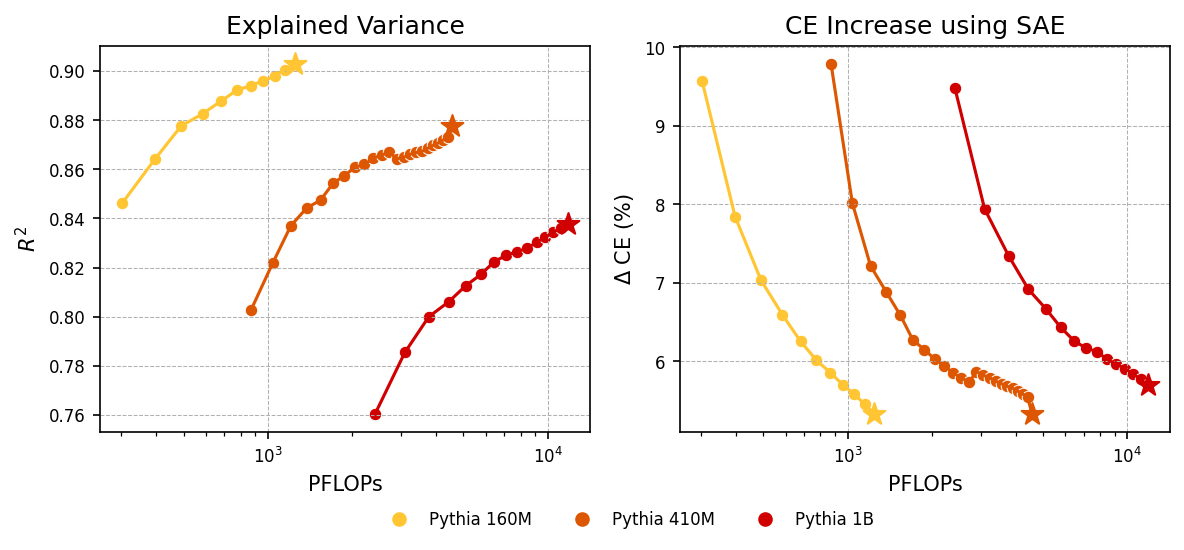

In [293]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3.5), dpi=150, layout="tight")
ax[0].grid(linestyle="--", linewidth=0.5)
ax[1].grid(linestyle="--", linewidth=0.5)

# Plot the two metrics
plot_vs_flops("explained_variance", ax[0])
ax[0].set_ylabel(r"$R^2$")
ax[0].set_title("Explained Variance")

plot_vs_flops("delta_ce", ax[1])
ax[1].set_ylabel(r"$\Delta$ CE (%)")
ax[1].set_title("CE Increase using SAE")

# Create a single unique legend without a frame
handles = [
    plt.Line2D([0], [0], marker='o', color=palette[0], linestyle='', label="Pythia 160M"),
    plt.Line2D([0], [0], marker='o', color=palette[2], linestyle='', label="Pythia 410M"),
    plt.Line2D([0], [0], marker='o', color=palette[3], linestyle='', label="Pythia 1B")
]
fig.legend(handles=handles, loc="lower center", ncol=3, fontsize=8, frameon=False, bbox_to_anchor=(0.53, -0.05))
plt.savefig("imgs/flops_vs_metrics.svg", bbox_inches="tight", dpi=300)
plt.show()

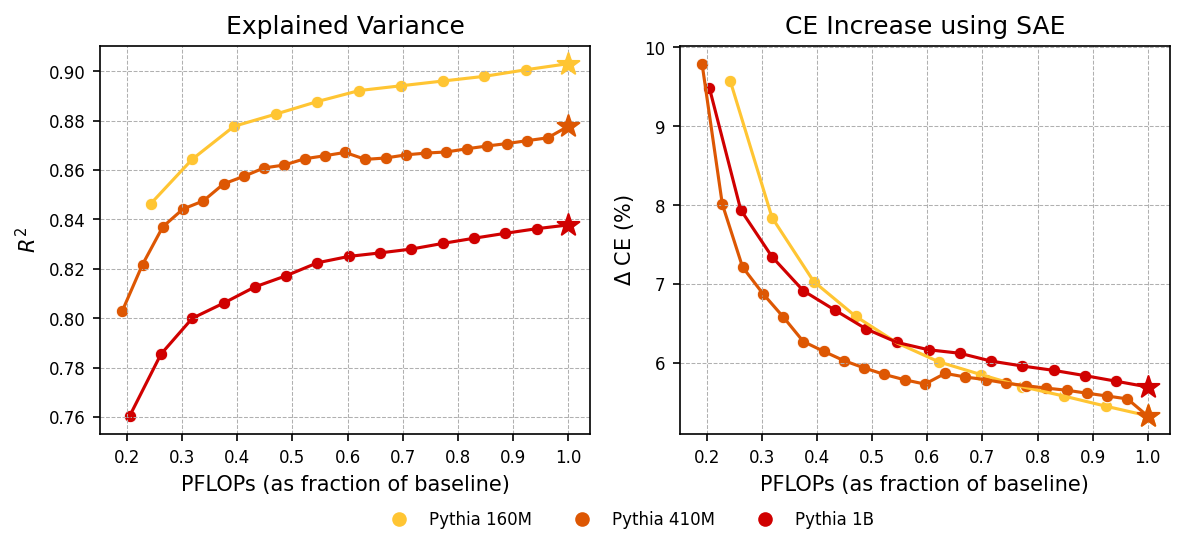

In [308]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3.5), dpi=150, layout="tight")
ax[0].grid(linestyle="--", linewidth=0.5)
ax[1].grid(linestyle="--", linewidth=0.5)

# Plot the two metrics
plot_vs_flops("explained_variance", ax[0], relative=True)
ax[0].set_ylabel(r"$R^2$")
ax[0].set_title("Explained Variance")
ax[0].set_xlabel("PFLOPs (as fraction of baseline)")

plot_vs_flops("delta_ce", ax[1], relative=True)
ax[1].set_ylabel(r"$\Delta$ CE (%)")
ax[1].set_title("CE Increase using SAE")
ax[1].set_xlabel("PFLOPs (as fraction of baseline)")


#all_ = pd.concat([p160_plot, p410_plot, p1_plot])
#max_ = all_["explained_variance"].max()
#min_ = all_["explained_variance"].min()
#delta = (max_ - min_) / 15
#ax[0].vlines(0.45, max_+delta, min_-delta, colors="grey", linestyles="--", linewidth=0.8)
#ax[0].axvspan(0.4, 0.5, color="lightgray", alpha=0.2)  # Light gray with transparency

# Create a single unique legend without a frame
handles = [
    plt.Line2D([0], [0], marker='o', color=palette[0], linestyle='', label="Pythia 160M"),
    plt.Line2D([0], [0], marker='o', color=palette[2], linestyle='', label="Pythia 410M"),
    plt.Line2D([0], [0], marker='o', color=palette[3], linestyle='', label="Pythia 1B")
]
fig.legend(handles=handles, loc="lower center", ncol=3, fontsize=8, frameon=False, bbox_to_anchor=(0.53, -0.05))
plt.savefig("imgs/relative_flops_vs_metrics.svg", bbox_inches="tight", dpi=300)
plt.show()

## Single-layer Reconstruction 

In [68]:
p160 = load_cluster_eval("160m", include_baseline=True)
p410 = load_cluster_eval("410m", include_baseline=True)
p1 = load_cluster_eval("1b", include_baseline=True)

eval_dict = {
    "160M": p160,
    "410M": p410,
    "1B": p1
}

In [271]:
ylabel_map = {
    'delta_ce': r'$\Delta$% CE',
    'explained_variance': '$R^2$',
    'mse': '$L_2$',
    'l0': '$L_0$'
}

y_lim_map = {
    'delta_ce': (0, 15.5),
    'explained_variance': (0, 1.05),
    'mse': (0, 110),
    'l0': (0, 250)
}

offset_map = {
    'delta_ce': 0.2,
    'explained_variance': 0.01,
    'mse': 1,
    'l0': 5
}

In [272]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.ticker import FuncFormatter

suptitle_fontsize = 16
title_fontsize = 16
label_fontsize = 14
tick_fontsize = 12
annot_fontsize = 6.5

label_pad = 8
title_pad = 10


def plot_reconstruction_single_layer(size, G, save=False):
    # Create a figure with 2 subplots in a 1x2 layout
    fig, ax = plt.subplots(1, 2, figsize=(14, 4.5), dpi=150, layout="tight")

    # Get the cluster IDs for the specific k value
    size = size.upper()
    n_layers = MODEL_MAP[f"pythia-{size.lower()}"]["n_layers"]
    eval_df = eval_dict[size]
    sub_df = eval_df[(eval_df["G"] == G) | (eval_df["G"] == n_layers - 1)]
    expanded_palette = sns.blend_palette(palette, n_colors=len(sub_df["cluster"].unique()) - 1)
    expanded_palette.append("#ced4da")

    # Loop over the metrics and create each subplot
    for i, metric in enumerate(["explained_variance", "delta_ce"]):
        # Loop over each layer and add it to the plot
        for layer in np.arange(n_layers - 1):
            subset = sub_df[sub_df["layer"] == layer]

            # Choose colors: first element for the Baseline, second for the comparison
            subset_colors = [expanded_palette[subset["cluster"].iloc[0]], "#ced4da"]

            sns.barplot(
                data=subset,
                x="layer",
                y=metric,
                hue="G",
                dodge=True,
                ax=ax[i],
                zorder=2,
                palette=subset_colors,
                legend=False,
            )

            delta_pct = (
                (subset[metric].iloc[0] - subset[metric].iloc[1]) / subset[metric].iloc[0] * 100
            )
            ax[i].text(
                layer,
                max(subset[metric]) + offset_map[metric],  # Position text slightly above the bar
                f"{'+' if delta_pct >= 0 else '-'}{abs(delta_pct):.1f}%",
                ha="center",
                va="bottom",
                fontsize=annot_fontsize,
                color="black",
                rotation=-0,
            )

        ylims = (
            (0.5, 1.05) if metric == "explained_variance" else (0, sub_df["delta_ce"].max() + 2)
        )

        # Add vertical lines to separate layer groups
        c = 0
        z = 1
        for j, new_c in enumerate(
            sub_df[sub_df["G"] == G]["cluster"]
        ):  # Avoid adding a line after the last layer
            if new_c != c:
                ax[i].axvline(x=j - 0.5, color="black", linestyle="--", linewidth=0.8)
                c = new_c
                ax[i].text(
                    j - 0.5 - z * 0.5,
                    ylims[1] * 0.99,
                    rf"$g_{c-1}$",
                    ha="center",
                    va="top",
                    fontsize=annot_fontsize+1.5,
                    color="black",
                )
                z = 0
            z += 1
        ax[i].text(
            n_layers - 1 - 0.5 - z * 0.5,
            ylims[1] * 0.99,
            rf"$g_{ {c} }$",
            ha="center",
            va="top",
            fontsize=annot_fontsize+1.5,
            color="black",
        )

        ax[i].set_title(ylabel_map[metric], pad=title_pad, fontsize=label_fontsize)
        ax[i].set_ylim(ylims)
        ax[i].set_xlabel("Layer", labelpad=label_pad, fontsize=label_fontsize)
        ax[i].set_ylabel("")
        ax[i].tick_params(axis="x", labelsize=tick_fontsize)
        ax[i].tick_params(axis="y", labelsize=tick_fontsize)
        ax[i].grid(color="#adb5bd", linestyle="--", linewidth=0.5)

        # For the right plot, add a plus sign and percent symbol to the y-tick labels
        if i == 1:
            ax[i].yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{x:.0f}%"))

    plt.suptitle(f"Pythia {size} - G{G}", fontsize=suptitle_fontsize)
    plt.subplots_adjust(hspace=0.4)

    if save:
        plt.savefig(f"imgs/layer_recon_{size}_G{G}.pdf", dpi=300, bbox_inches="tight")

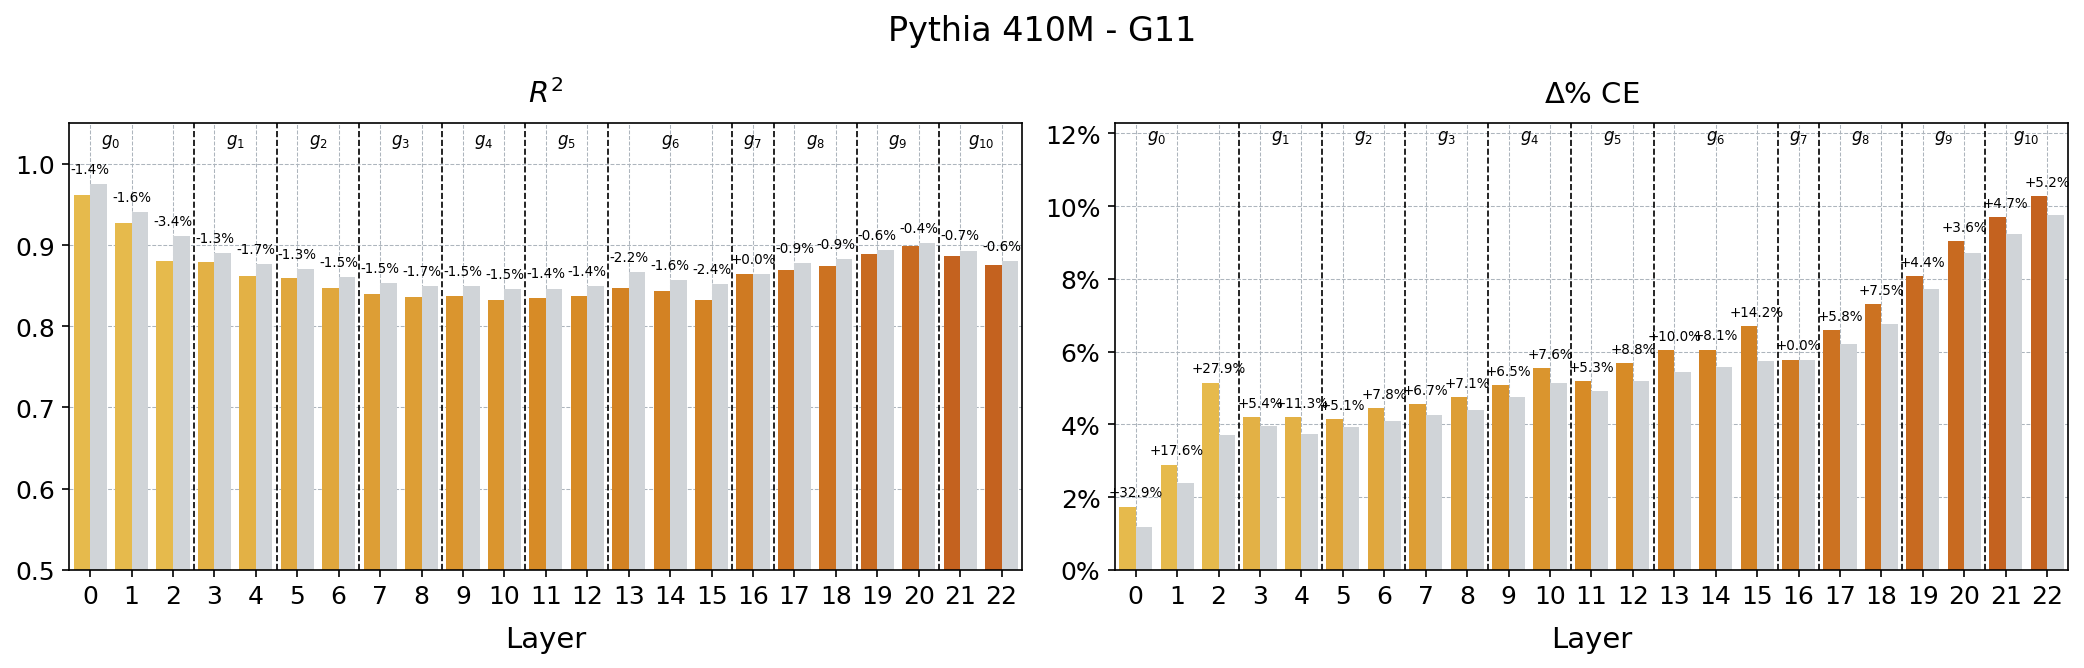

In [273]:
plot_reconstruction_single_layer("410M", 11, save=False)

In [ ]:
for size in ['160M', '410M', '1B']:
    for G in range(1, MODEL_MAP[f"pythia-{size.lower()}"]["n_layers"] - 1):
        plot_reconstruction_single_layer(size, G, save=True)

In [275]:
suptitle_fontsize = 16
title_fontsize = 16
label_fontsize = 14
tick_fontsize = 12
annot_fontsize = 7

label_pad = 8
title_pad = 10

def plot_reconstruction_average(size, save=False):
    # Create a figure with 2 subplots in a 1x2 layout
    fig, ax = plt.subplots(1, 2, figsize=(14, 4.5), dpi=150, layout="tight")

    # Get the cluster IDs for the specific k value
    size = size.upper()
    n_layers = MODEL_MAP[f"pythia-{size.lower()}"]["n_layers"]
    eval_df = eval_dict[size].groupby("G").mean()
    g_label = list(range(1, n_layers - 1)) + ["B"]
    eval_df["G_label"] = g_label

    # Generate the expanded palette by interpolating between the base colors
    expanded_palette = sns.blend_palette(palette, n_colors=n_layers - 2)
    expanded_palette.append("#ced4da")
    for i, metric in enumerate(["explained_variance", "delta_ce"]):

        sns.barplot(
            data=eval_df,
            x="G_label",
            hue="G_label",
            y=metric,
            ax=ax[i],
            zorder=2,
            palette=expanded_palette,
            legend=False,
        )

        baseline_value = eval_df.loc[eval_df["G_label"] == "B", metric].iloc[0]
        for j, patch in enumerate(ax[i].patches):
            current_label = g_label[j]
            current_value = patch.get_height()
            # Calculate the delta percentage with respect to the baseline.
            delta_pct = (current_value - baseline_value) / baseline_value * 100

            # For the baseline bar you may simply show "0%"; for others, include a '+' sign if nonnegative.
            text = "0%" if current_label == "B" else f"{'+' if delta_pct >= 0 else ''}{delta_pct:.1f}%"

            # Position the text: center of the bar horizontally, and just above the bar.
            x = patch.get_x() + patch.get_width() / 2.
            y = current_value + offset_map[metric]
            ax[i].text(x, y, text, ha="center", va="bottom", fontsize=annot_fontsize)

        ylims = (0.5, 1.05) if metric == "explained_variance" else (0, eval_df["delta_ce"].max() + 2)
        ax[i].set_title(ylabel_map[metric], pad=title_pad, fontsize=label_fontsize)
        ax[i].set_ylim(ylims)
        ax[i].set_xlabel("G", labelpad=label_pad, fontsize=label_fontsize)
        ax[i].set_ylabel("")
        ax[i].tick_params(axis="x", labelsize=tick_fontsize)
        ax[i].tick_params(axis="y", labelsize=tick_fontsize)
        ax[i].grid(color="#adb5bd", linestyle="--", linewidth=0.5)

        # For the right plot, add a plus sign and percent symbol to the y-tick labels
        if i == 1:
            ax[i].yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{x:.0f}%"))

    plt.suptitle(f"Pythia {size}", fontsize=suptitle_fontsize)
    plt.subplots_adjust(hspace=0.4)

    if save:
        plt.savefig(f"imgs/avg_recon_{size}.pdf", dpi=300, bbox_inches="tight")

In [ ]:
plot_reconstruction_average("410M")

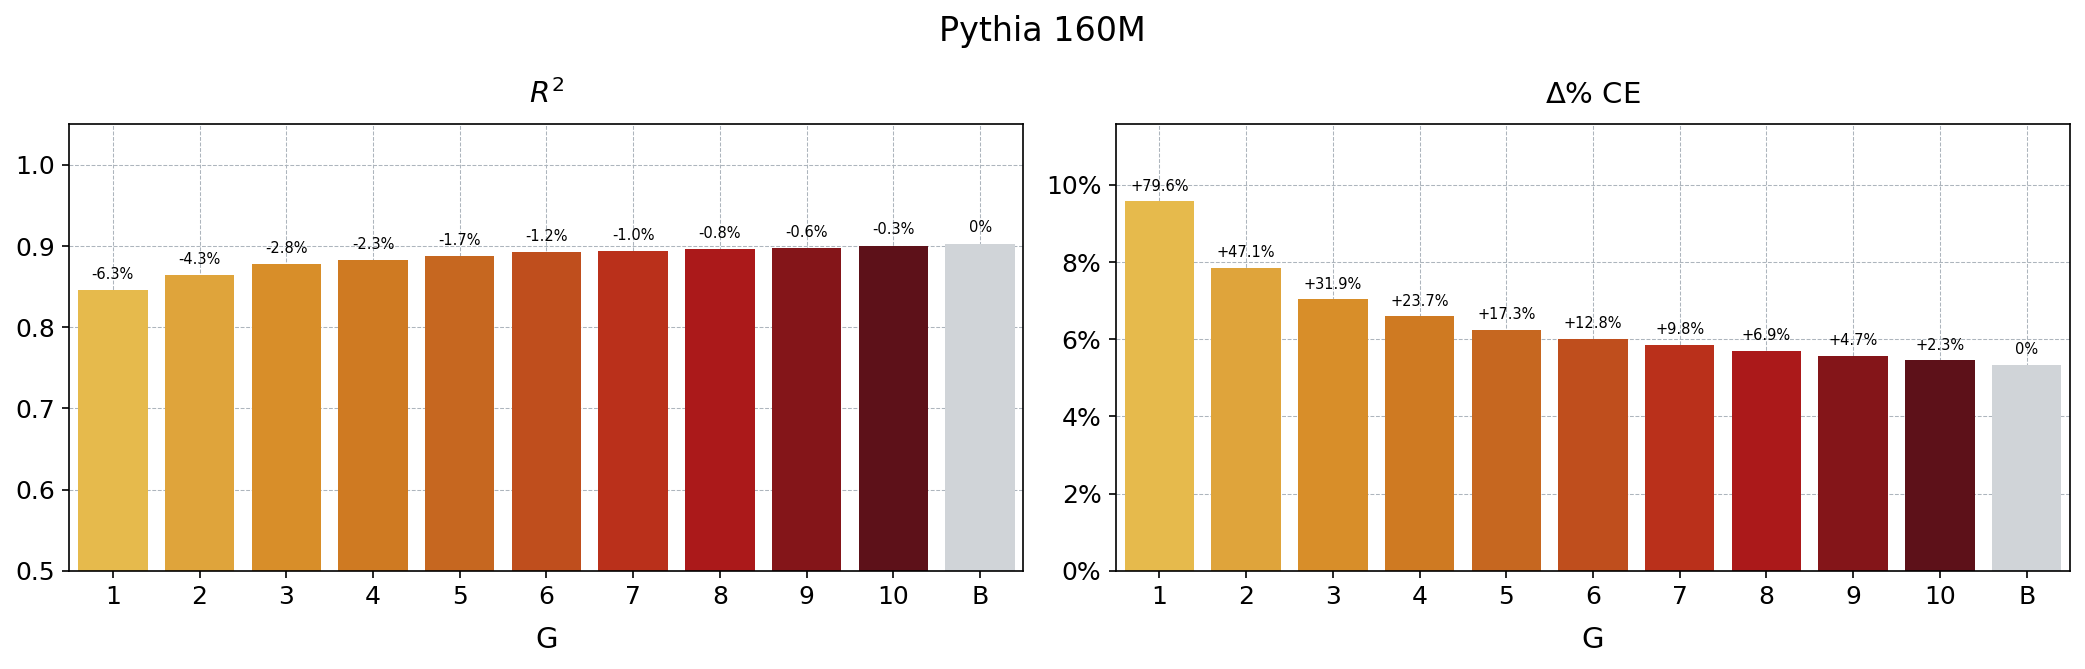

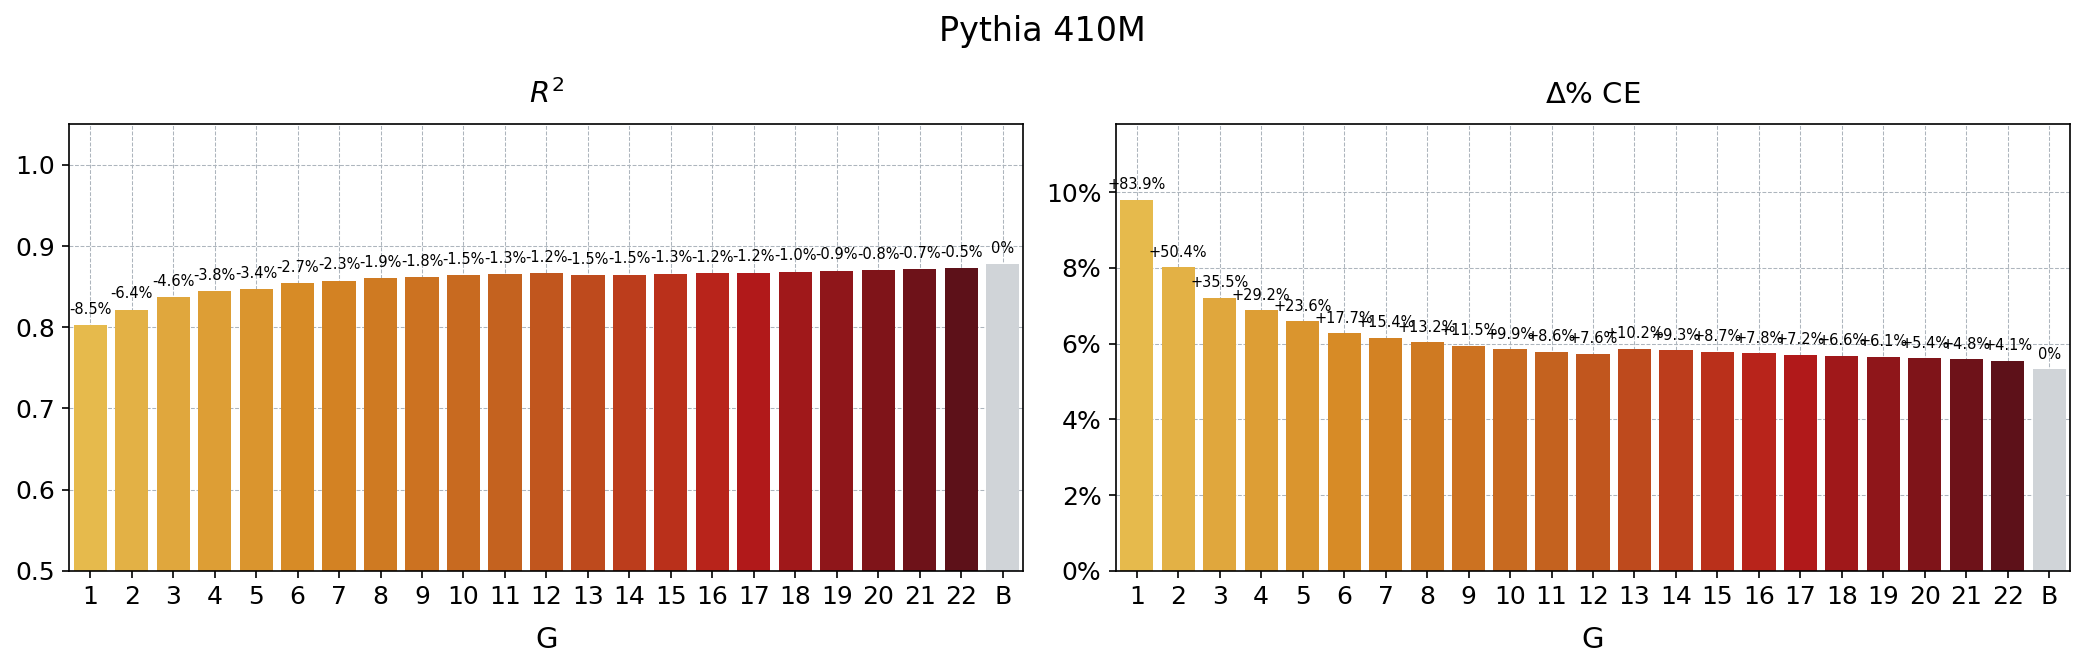

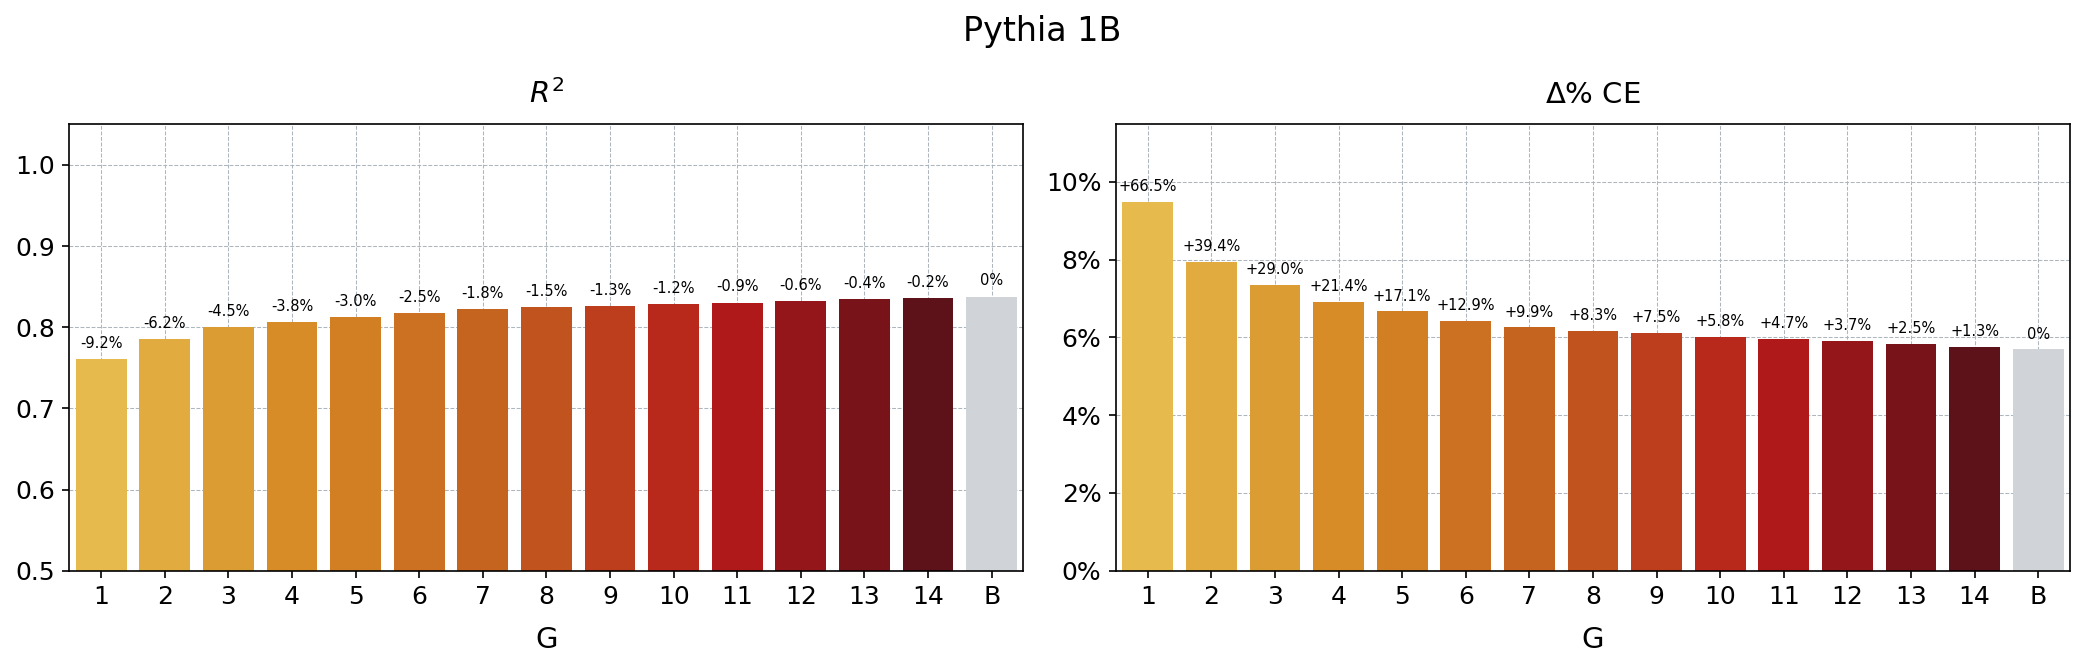

In [277]:
for size in ['160M', '410M', '1B']:
    plot_reconstruction_average(size, save=True)

## Auto-interpretability